## Wasserstein GAN Implementation

Based on the paper: <i>Wasserstein Generative Adversarial Networks</i>. There are good references [here](https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/) and [here](https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/).

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.layers import Input,Dense,Reshape,Dropout,BatchNormalization,Activation,UpSampling2D,Embedding
from tensorflow.keras.layers import BatchNormalization,Conv2D,LeakyReLU,Flatten,Conv2DTranspose,Concatenate
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
tf.keras.backend.set_floatx('float32')

import warnings
warnings.filterwarnings('ignore')

### Data Cleaning

In [2]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_train = x_train[y_train <= 3] # using numbers 0,1,2,3
y_train = y_train[y_train <= 3]
y_train = y_train.astype("int32")
y_train = np.expand_dims(y_train,axis=-1)
x_train = (x_train-127.5)/127.5 # scaling the images
x_train = np.expand_dims(x_train,axis=-1)
x_train = x_train[:24750]
y_train = y_train[:24750]
print(x_train.shape,y_train.shape)

(24750, 28, 28, 1) (24750, 1)


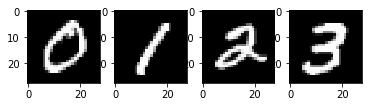

In [3]:
plt.subplot(1,4,1)
plt.imshow(np.squeeze(x_train[0]),cmap="gray")
plt.subplot(1,4,2)
plt.imshow(np.squeeze(x_train[1]),cmap="gray")
plt.subplot(1,4,3)
plt.imshow(np.squeeze(x_train[2]),cmap="gray")
plt.subplot(1,4,4)
plt.imshow(np.squeeze(x_train[4]),cmap="gray")
plt.show()

### Model Implementation

Brief description: we want to <b>maximize</b> the critic score for <u>fake</u> images and <b>minimize</b> the critic score for <u>real</u> images; therefore loss_fake-img = <b>-1</b>\*critic_score while loss_real-img = critic_score (this is intuitive when remembering gradient descent is minimizing -1\*critic_score_fake-img + critic_score_real-img).

In [4]:
def get_generator(noise_dim=100):
    """ generator implementation
    """
    z = Input(shape=(noise_dim))
    h = Dense(7*7*256)(z)
    h = LeakyReLU(0.2)(h)
    h = Reshape((7,7,256))(h)
    
    h = UpSampling2D()(h)
    h = Conv2D(filters=128,kernel_size=4,strides=1,padding='same',activation=None)(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(0.2)(h)
    h = UpSampling2D()(h)
    h = Conv2D(filters=128,kernel_size=4,strides=1,padding='same',activation=None)(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(filters=1,kernel_size=4,strides=1,padding='same',activation=None)(h)
    h = Activation('tanh')(h)
    
    model = Model(inputs=z,outputs=h)
    return model

In [5]:
class Clipped(Constraint):
    """ clips weights of the discriminator(critic) to predetermined range
    """
    def __init__(self,clip_value):
        self.clip_value = clip_value

    def __call__(self, w):        
        return K.clip(w,-self.clip_value,self.clip_value)

    def get_config(self):
        return {'clip_value': self.clip_value}

In [6]:
def get_discriminator():
    """ discriminator(critic) implementation
    """
    x = Input(shape=(28,28,1))

    h = Conv2D(filters=64,kernel_size=4,strides=2,padding='same',kernel_constraint=Clipped(0.01),activation=None)(x)
    h = BatchNormalization()(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(filters=64,kernel_size=4,strides=2,padding='same',kernel_constraint=Clipped(0.01),activation=None)(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(0.2)(h)
    h = Flatten()(h)
    h = Dense(1,activation=None)(h) # linear
    
    model = Model(inputs=x,outputs=h)
    return model

In [7]:
def wasserstein_loss(y_true,y_pred):
    """ loss implementation
    """
    return K.mean(y_true*y_pred)

In [8]:
def discriminator_model(discriminator,optimizer=RMSprop(lr=0.00005)):
    """ compiling discriminator model
    """
    x = Input(shape=(28,28,1))
    out = discriminator(x)
    
    model = Model(inputs=x,outputs=out)
    model.compile(loss=wasserstein_loss,optimizer=optimizer)
    return model

In [9]:
def adversarial_model(generator,discriminator,noise_dim=100,optimizer=RMSprop(lr=0.00005)):
    """ compiling adversarial model - used to train generator
    """
    z = Input(shape=(noise_dim))
    gen = generator(z)
    out = discriminator(gen)
    
    model = Model(inputs=z,outputs=out)
    model.compile(loss=wasserstein_loss,optimizer=optimizer)
    return model

In [10]:
d = get_discriminator()
generator = get_generator()
discriminator = discriminator_model(d)
adversarial = adversarial_model(generator,d)

### Model Training

The noise prior z~N(0,1)

In [12]:
num_epochs=10
batch_size=50
n_critic=5

for epoch_i in range(num_epochs):
    all_a_losses = []
    all_d1_losses = []
    all_d2_losses = []
    print("Epoch {}:".format(epoch_i+1))
    
    for i in range(0,len(x_train)-batch_size*(n_critic-1),batch_size):
        x_subset = x_train[i:i+batch_size*n_critic]
        
        # training the discriminator:
        discriminator.trainable=True
        for nc_i in range(n_critic):
            z = np.random.normal(0.0,1.0,size=(int(batch_size/2),100))
            x_gen = generator(z)
            # training disc. w/ real examples
            disc_x = x_subset[nc_i*batch_size:nc_i*batch_size+int(batch_size/2)]
            disc_y = np.ones((int(batch_size/2),1))
            d_loss = discriminator.train_on_batch(disc_x,disc_y)
            all_d1_losses.append(float(d_loss))
            # training disc. w/ fake examples
            disc_x = x_gen
            disc_y = -1*np.ones((int(batch_size/2),1))
            d_loss = discriminator.train_on_batch(disc_x,disc_y)
            all_d2_losses.append(float(d_loss))
        
        # training the generator:
        y = np.ones([batch_size,1]) # we switch the labels here to maximize the domain-confusion
        z = np.random.normal(0.0,1.0,size=(batch_size,100))
        discriminator.trainable=False
        a_loss = adversarial.train_on_batch(z,y)
        all_a_losses.append(float(a_loss))
        
        if i%2000 == 0:
            plt.figure(figsize=(15,4))
            for i in range(10):
                this_noise = np.random.normal(0.0,1.0,size=(1,100))
                gen = generator(this_noise).numpy()
                gen.shape=(28,28)
                plt.subplot(1,10,i+1)
                plt.imshow(gen,cmap="gray")
            plt.show()
            
    print("gen. loss:{}; disc. 1 loss:{}; disc. 2 loss:{}".format(sum(all_a_losses)/len(all_a_losses),sum(all_d1_losses)/len(all_d1_losses),sum(all_d2_losses)/len(all_d2_losses)))            
    print("--------------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------------")

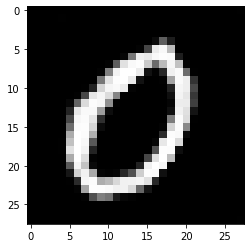

In [19]:
this_noise = np.random.normal(0.0,1.0,size=(1,100))
gen = generator(this_noise).numpy()
gen.shape=(28,28)
plt.imshow(gen,cmap="gray")
plt.show()

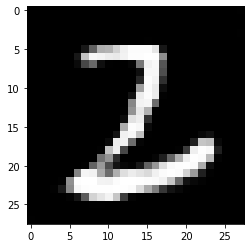

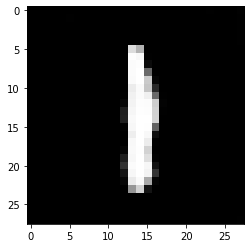

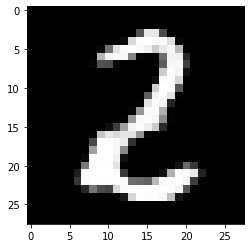

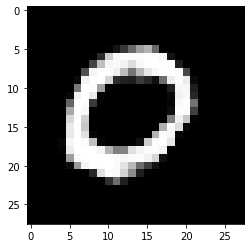

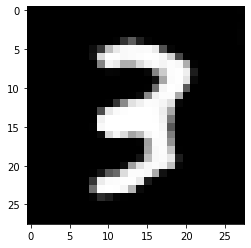

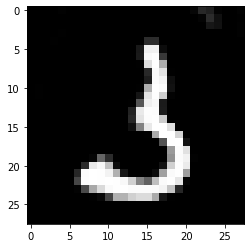

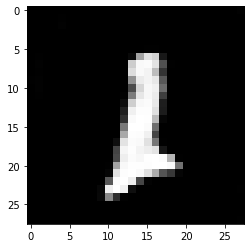